In [123]:
# Import Module
import pandas as pd
import numpy as np
from pylab import *
import seaborn as sns
import matplotlib.pyplot as plt # for plotting
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Download necessary NLTK data
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

from nltk.tokenize import word_tokenize

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [125]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [159]:
# Read the CSV file using different parsing options
try:
    df = pd.read_csv('/content/data job posts.csv', error_bad_lines=False)
except pd.errors.ParserError as e:
    print("ParserError:", e)
    print("Attempting to read file with alternate options...")
    try:
        df = pd.read_csv('/content/data job posts.csv', sep=',', quotechar='"', encoding='utf-8')
        print("File read successfully with alternate options.")
    except pd.errors.ParserError as e:
        print("Unable to read file. Please check for formatting issues.")


<ipython-input-159-48b5fa109cee>:3: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv('/content/data job posts.csv', error_bad_lines=False)


In [160]:
df.columns

Index(['jobpost', 'date', 'Title', 'Company', 'AnnouncementCode', 'Term',
       'Eligibility', 'Audience', 'StartDate', 'Duration', 'Location',
       'JobDescription', 'JobRequirment', 'RequiredQual', 'Salary',
       'ApplicationP', 'OpeningDate', 'Deadline', 'Notes', 'AboutC', 'Attach',
       'Year', 'Month', 'IT'],
      dtype='object')

In [161]:
df['Title'].value_counts()

Accountant                                                 328
Chief Accountant                                           219
Medical Representative                                     216
Sales Manager                                              166
Administrative Assistant                                   155
                                                          ... 
Public Relations and Marketing Manager                       1
Software Developer (Ajax, ASP .Net)                          1
Software Developer (Ajax, PHP)                               1
Analyst, Analysis Division, Financial Monitoring Center      1
Head of Online Sales Department                              1
Name: Title, Length: 8636, dtype: int64

In [162]:
df.shape

(19001, 24)

In [163]:
df = df.loc[:,['Title','JobRequirment', 'RequiredQual']]

In [164]:
df.isna().sum().sum()

3034

In [165]:
print(df.shape)
df.dropna(inplace=True)
print(df.shape)

(19001, 3)
(16455, 3)


In [166]:
df.isna().sum().sum()

0

In [167]:
# Count the occurrences of each title
title_counts = df['Title'].value_counts()

# Filter the DataFrame to include only records with count of "Title" > 100
filtered_titles = title_counts[title_counts > 100].index

filtered_titles

Index(['Accountant', 'Chief Accountant', 'Medical Representative',
       'Sales Manager', 'Administrative Assistant', 'Lawyer',
       'Project Manager'],
      dtype='object')

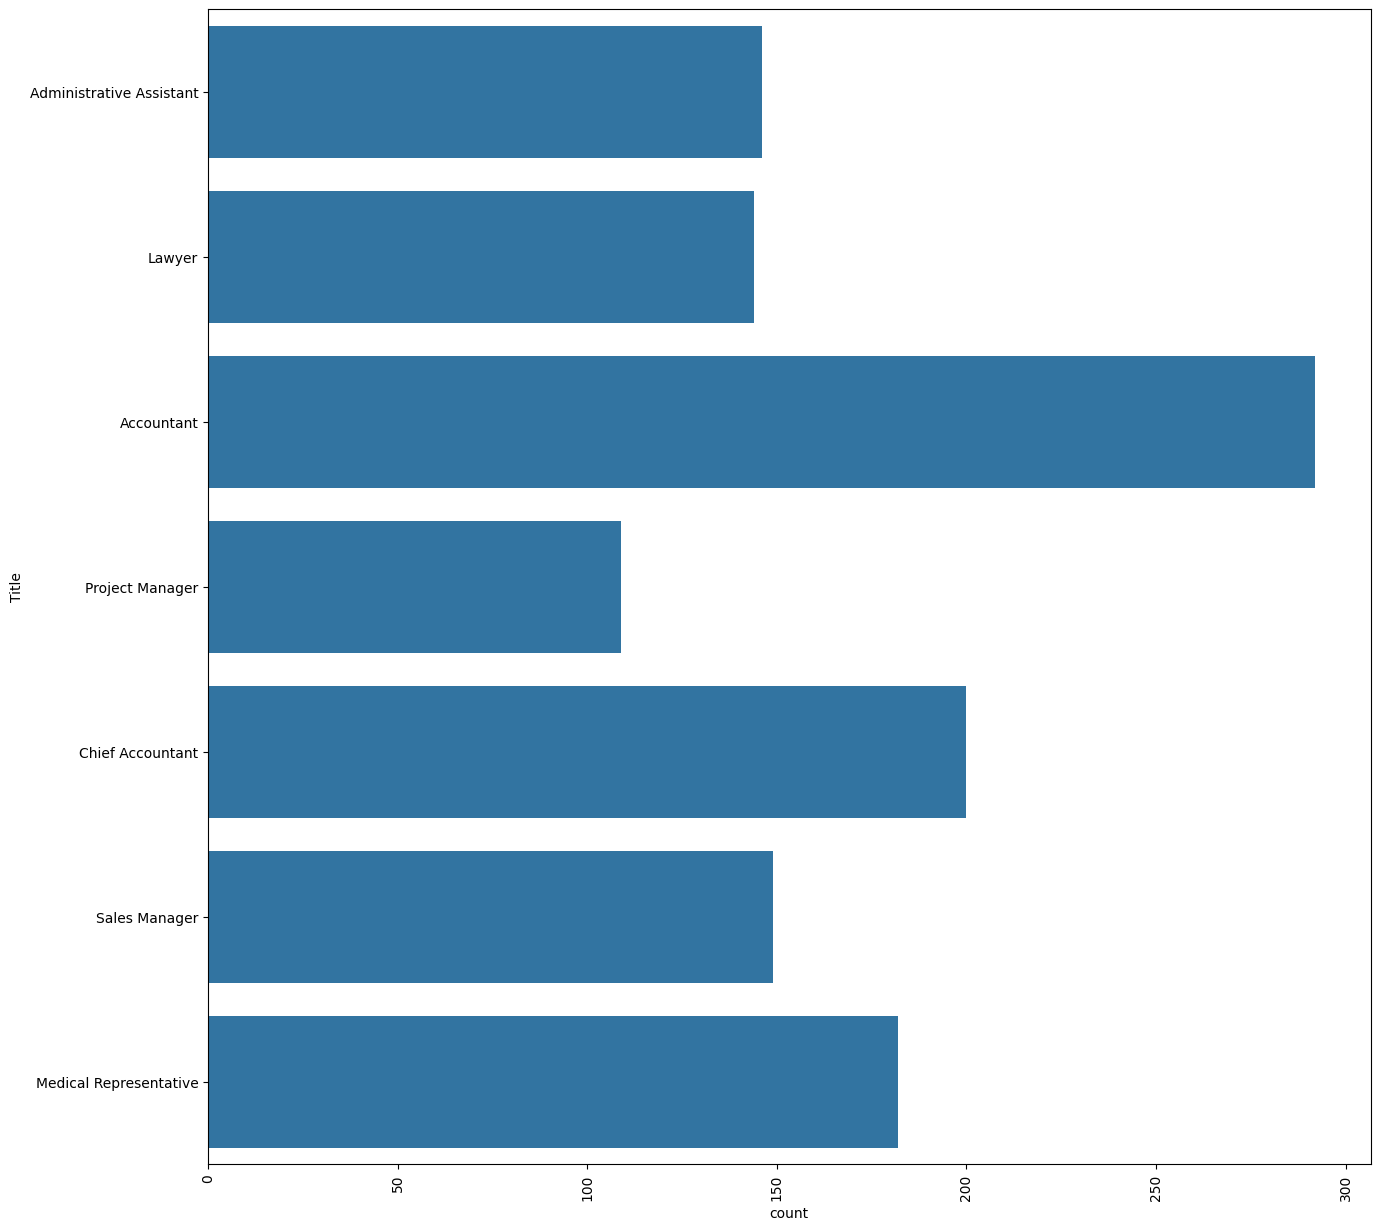

In [168]:
# Filter the DataFrame based on the filtered titles
df = df[df['Title'].isin(filtered_titles)]

# Now you can create the countplot using the filtered DataFrame
plt.figure(figsize=(15, 15))
plt.xticks(rotation=90)
sns.countplot(y="Title", data=df)
plt.show()

In [169]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1222 entries, 20 to 18943
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Title          1222 non-null   object
 1   JobRequirment  1222 non-null   object
 2   RequiredQual   1222 non-null   object
dtypes: object(3)
memory usage: 38.2+ KB


In [170]:
# Preprocess the JobRequirement text data
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove special characters
    text = re.sub(r'\r\n', ' ', text) # replace carriage returns with space
    text = re.sub(r'[^\w\s]', '', text) # remove punctuation
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    word_list = nltk.word_tokenize(text)
    text = ' '.join([lemmatizer.lemmatize(w) for w in word_list if w not in stopwords.words('english')])
    return text


In [171]:
def remove_words(text, words):
    for word in words:
        text = text.replace(word, '')
    return text

In [172]:
# Preprocess the JobRequirement column and drop NaNs
df['JobRequirmentProcessed'] = df['JobRequirment'].dropna().apply(preprocess_text)


In [173]:
df['RequiredQualProcessed'] = df['RequiredQual'].dropna().apply(preprocess_text)

In [174]:
print(df['JobRequirmentProcessed'])
print(df['RequiredQualProcessed'])

20       responsible managing office administration inc...
21       drawing juridical document drawing contract ve...
74       manage program financial system budget organiz...
77       provide translation interpretation service pro...
95       daily management project activity leading supe...
                               ...                        
18892    implement daytoday journal entry well monthend...
18906    ensure consultation national counterpart techn...
18924    actively inform doctor pharmacist need exclusi...
18931    implement daytoday journal entry well monthend...
18943    guide project team proper timely implementatio...
Name: JobRequirmentProcessed, Length: 1222, dtype: object
20       fluency spoken written english knowledge europ...
21       university degree jurisprudence experience fol...
74       written oral fluency english armenian russian ...
77       excellent communication skill friendly persona...
95       advanced university degree public health relat..

In [175]:
df['text'] = (df['JobRequirmentProcessed'] + ' ' + df['RequiredQualProcessed']).tolist()

In [176]:
words_to_eliminate = [
      "prepare", "company", "perform", "work", "team", "include", "ensure",
      "provide", "related", "office", "plan", "role", "activity",
      "responsibility", "system", "control", "product", "information",
      "design", "arrangement", "proper", "arrange", "act", "application", "assessment",
      "follow", "improvement", "introduce", "involve", "issue", "item", "join",
      "keep", "know", "leave", "level", "line", "list", "listen", "live", "look",
      "lose", "maintain", "mandate", "manner", "etc", 'office', 'communication', 'work','good',
      'english', 'knowledge', 'language', 'skill', 'tax', 'setup', 'telephonic', 'cut', 'safetyrelated',
      'resourcesrelated', 'entail', 'normal', 'accompanying', 'humour', 'wideranging'
  ]


In [177]:
# Apply the function to the text column
df['text'] = df['text'].apply(lambda x: remove_words(x, words_to_eliminate))

In [178]:
df.head()

,Title,JobRequirment,RequiredQual,JobRequirmentProcessed,RequiredQualProcessed,text
20,Administrative Assistant,- Responsible for managing office administrati...,- Fluency in spoken and written English; knowl...,responsible managing office administration inc...,fluency spoken written english knowledge europ...,responsible managing administration including...
21,Lawyer,- Drawing up juridical documents;\r\n- Drawing...,- University degree in Jurisprudence;\r\n- Exp...,drawing juridical document drawing contract ve...,university degree jurisprudence experience fol...,drawing juridical document drawing contr verif...
74,Accountant,- Manage program financial system and budget o...,"- Written and oral fluency in English, Armenia...",manage program financial system budget organiz...,written oral fluency english armenian russian ...,manage program financial budget organization ...
77,Administrative Assistant,- Provide translation and interpretation servi...,- Excellent communication skills. Friendly per...,provide translation interpretation service pro...,excellent communication skill friendly persona...,translation interpretation service profession...
95,Project Manager,- Daily management of project activities by le...,- Advanced university degree in public health ...,daily management project activity leading supe...,advanced university degree public health relat...,daily management project leading supervising ...


In [152]:
df['text'].info()

<class 'pandas.core.series.Series'>
Int64Index: 1222 entries, 20 to 18943
Series name: text
Non-Null Count  Dtype 
--------------  ----- 
1222 non-null   object
dtypes: object(1)
memory usage: 19.1+ KB


In [153]:
df['text'].head(n=2)

20    responsible managing office administration inc...
21    drawing juridical document drawing contract ve...
Name: text, dtype: object

In [179]:
df.head()

,Title,JobRequirment,RequiredQual,JobRequirmentProcessed,RequiredQualProcessed,text
20,Administrative Assistant,- Responsible for managing office administrati...,- Fluency in spoken and written English; knowl...,responsible managing office administration inc...,fluency spoken written english knowledge europ...,responsible managing administration including...
21,Lawyer,- Drawing up juridical documents;\r\n- Drawing...,- University degree in Jurisprudence;\r\n- Exp...,drawing juridical document drawing contract ve...,university degree jurisprudence experience fol...,drawing juridical document drawing contr verif...
74,Accountant,- Manage program financial system and budget o...,"- Written and oral fluency in English, Armenia...",manage program financial system budget organiz...,written oral fluency english armenian russian ...,manage program financial budget organization ...
77,Administrative Assistant,- Provide translation and interpretation servi...,- Excellent communication skills. Friendly per...,provide translation interpretation service pro...,excellent communication skill friendly persona...,translation interpretation service profession...
95,Project Manager,- Daily management of project activities by le...,- Advanced university degree in public health ...,daily management project activity leading supe...,advanced university degree public health relat...,daily management project leading supervising ...


In [180]:
df = df.loc[:,['Title','text']]

In [181]:
df.head()

,Title,text
20,Administrative Assistant,responsible managing administration including...
21,Lawyer,drawing juridical document drawing contr verif...
74,Accountant,manage program financial budget organization ...
77,Administrative Assistant,translation interpretation service profession...
95,Project Manager,daily management project leading supervising ...


In [182]:
# Convert the column DataFrame to CSV
df.to_csv('Preprocessed_DataSet.csv', index=False)

# Download the CSV file
from google.colab import files
files.download('Preprocessed_DataSet.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>